In [1]:
# Loading modules

%matplotlib inline
import numpy as np
import glob, os, sys, time
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import interp1d
from PTEmu import PTEmu

# Set base directory
base_dir = '..'

# Setup of emulator

In [2]:
# Parameter ranges (not necessary after the training samples have been generated, but useful to know!)
ranges = {}
ranges['s12'] = [0.2, 1.0]
ranges['wc'] = [0.065, 0.165]
ranges['wb'] = [0.0217, 0.0225]
ranges['ns'] = [0.955, 0.965]
ranges['alpha_tr'] = [0.7, 1.3]
ranges['alpha_lo'] = [0.7, 1.3]
ranges['f'] = [0.5, 1.0]
ranges['avir'] = [0., 10.]

We begin by setting up an instance of the PTEmu class, which is simply created by providing a dictionary of parameter names, classified either into those that control the shape of the linear power spectrum (`SHAPE`) or those that control the amplitude and RSD modelling (`RSD`).

In [3]:
# Define which parameters are "SHAPE" and "RSD" parameters
params_definition = {'wc':'SHAPE','wb':'SHAPE','ns':'SHAPE',
                     's12':'RSD','alpha_tr':'RSD','alpha_lo':'RSD','f':'RSD'}

# Create instance of emulator class
EFT = PTEmu(params=params_definition)

Next, we have to read in the training data, consisting of tables of parameter values and corresponding model predictions, which have been combined into a single .fits file (see below for an explanation of the format). 

In [4]:
# Load training data sets (these are always required, no matter if the emulator has already been trained or not).
# This training set uses 500 samples for the SHAPE parameter space and 2000 for the combined one, it covers scales up to k = 0.35 1/Mpc
EFT.load_emulator_data(fname='{}/tables/EFT_wcwbns_sig12APf_Planck_n750:2500.fits'.format(base_dir))

Finally, we can proceed with the training of the emulator(s), or load previously trained emulators from disk. There are five separate emulator objects: 
- emulators for the linear power spetrum (`PL`) and sigma12 (`s12`), which operate on the `SHAPE` parameter space only
- emulators for the monopole, quadrupole, and hexadecapole contributions to the nonlinear power spectrum, which operate on the `SHAPE`+`RSD` parameter space

In [5]:
# Let's first train the emulator for PL and s12, which are model independent and can be re-used later
# EFT.train_emulator(data_type=['PL','s12'])
# EFT.save_emulator(fname_base='{}/models/Emu_shape'.format(base_dir), data_type=['PL','s12'])

# after the training, the emulators can be loaded as follows:
EFT.load_emulator(fname_base='{}/models/Emu_shape_Planck'.format(base_dir), data_type=['PL','s12'])

In [6]:
# Now we train the emulator for the full parameter set (remember: this depends on the specific RSD model!)
# EFT.train_emulator(data_type=[0,2,4])
# EFT.save_emulator(fname_base'{}/models/EFT_k0p5'.format(base_dir), data_type=[0,2,4])

# After the training, the emulator can be loaded as follows:
EFT.load_emulator(fname_base='{}/models/EFT_Planck'.format(base_dir), data_type=[0,2,4])

# Computing multipoles

## Using Mpc units

Before being able to use the emulator for predictions of the multipoles, we need to specify a number density (i.e., the inverse Poisson shot noise). At the same time, we configure the emulator to output results either in units of 1/Mpc (`use_Mpc = True`) or h/Mpc (`use_Mpc = False`) units. All quantities that are not dimensionless are then assumed to be given in the corresponding units.

In [7]:
# Let's configure the emulator in Mpc units (which is the default, if `use_MPC` is not set explicitly), the number density is therefore in units of 1/Mpc^3
EFT.define_data_set(use_Mpc=True, nbar=1.32904e-4)

# The higher-derivative contributions require a normalization scale `kHD`, such that e.g. ~ (k/kHD)^2 P(k) etc. By default this scale is set to 0.278 1/Mpc, or 0.4 h/Mpc.
# This can be changed by specifying it with `define_data_set`:
EFT.define_data_set(kHD=0.278)

The functions returning the multipoles take generally three arguments:
1. the scales for which to compute the multipoles: if given as a number or numpy array all specified multipoles will be computed for those scales, if given as a list, the length must match the number of specified multipoles (`ell`) and the first entry of the list is evaluated for the first multipole etc
2. a parameter dictionary, specifying shape + RSD parameters, as well as bias parameters
3. the multipole number, i.e. ell = 0, 2, 4, or a list of multipole numbers

In [8]:
# Let's create a parameter dictionary
params = {}

# We always need to specify the shape parameter values, e.g.
params['wc'] = 0.11544
params['wb'] = 0.0222191
params['ns'] = 0.9632

# For predictions using the RSD parameter space we also need to specify values for the following four parameters, e.g.
params['s12']      = 0.6
params['alpha_lo'] = 1.1
params['alpha_tr'] = 0.9
params['f']        = 0.7

# Finally, the bias parameters: any parameters from {b1, b2, g2, g21, c0, c2, c4, cnlo, N0, N20, N22} can be specified.
# Parameters, which are not explicitly specified are automatically set to zero. As an example, let's just set b1 and b2:
params['b1'] = 2.
params['b2'] = -0.5

We can output at a single scale and single multipole number, e.g. for the quadrupole at k = 0.1 1/Mpc:

In [9]:
# The provided scales are also assumed to be in 1/Mpc units
EFT.Pell(0.1, params, ell=2)

array(22656.1230077)

Or for various multipoles and multiple scales, in which case the output is a list with the first entry corresponding to the first multipole specified in `ell`:

In [10]:
EFT.Pell(np.array([0.1,0.2,0.3]), params, ell=[0,2,4])

[array([31051.74897869, 12372.13725961,  7527.99259006]),
 array([22656.1230077 , 11921.50762797,  8888.94065649]),
 array([5899.92070485, 3967.04315185, 3256.11876245])]

Or at different scales for different multipoles (providing a list of numbers or numpy arrays):

In [11]:
EFT.Pell([np.array([0.1,0.2]),0.3], params, ell=[0,4])

[array([31051.74897869, 12372.13725961]), array(3256.11876245)]

Let's generate two different sets of predicitons for different parameter values and plot the results:

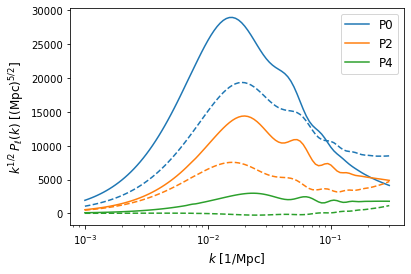

In [12]:
# Define range of scales (remember: in 1/Mpc)
k_Mpc = np.logspace(-3,np.log10(0.3),100)

# get multipoles (in Mpc^3)
Pell_Mpc_1 = EFT.Pell(k_Mpc, params, ell=[0,2,4])

# Now, let's add/change some parameter values and obtain a second set of predictions
params['alpha_tr'] = 1.2
params['g2']       = -0.3
params['c0']       = -4.
params['cnlo']     = 6.
params['N0']       = 0.6
Pell_Mpc_2 = EFT.Pell(k_Mpc, params, ell=[0,2,4])

# Plot the results!
f = plt.figure()
ax = f.add_subplot(111)

ax.semilogx(k_Mpc, k_Mpc**0.5*Pell_Mpc_1[0],c='C0',ls='-',label='P0')
ax.semilogx(k_Mpc, k_Mpc**0.5*Pell_Mpc_2[0],c='C0',ls='--')

ax.semilogx(k_Mpc, k_Mpc**0.5*Pell_Mpc_1[1],c='C1',ls='-',label='P2')
ax.semilogx(k_Mpc, k_Mpc**0.5*Pell_Mpc_2[1],c='C1',ls='--')

ax.semilogx(k_Mpc, k_Mpc**0.5*Pell_Mpc_1[2],c='C2',ls='-',label='P4')
ax.semilogx(k_Mpc, k_Mpc**0.5*Pell_Mpc_2[2],c='C2',ls='--')

ax.set_xlabel('$k$ [1/Mpc]',fontsize=12)
ax.set_ylabel(r'$k^{1/2}\,P_{\ell}(k)$ [$(\mathrm{Mpc})^{5/2}$]',fontsize=12)
ax.legend(fontsize=12)

## Using Mpc/h units

Now we switch to Mpc/h units, by calling `define_data_set` again and providing the number density in units of (h/Mpc)^3:

In [13]:
EFT.define_data_set(use_Mpc=False, nbar=3.95898e-4)

When computing the multipoles using the $\sigma_{12}$ parameter space we now additionally need to specify a fiducial value for the Hubble rate. This is required to convert the native emulator output from Mpc to Mpc/h units. So let's add this to the parameter dictionary:

In [14]:
params['h'] = 0.695

Now, we can compute the multipoles for the same range of scales, but in Mpc/h units:

In [15]:
# EFT.splines_up_to_date = [False]*3
k_hMpc = np.logspace(-3,np.log10(0.3),100)
Pell_hMpc_2 = EFT.Pell(k_hMpc,params,ell=[0,2,4])

After scaling `k_Mpc` and `Pell_Mpc_2` from above the results should be identical (apart from a different overall range of scales). Let's check this is really the case:

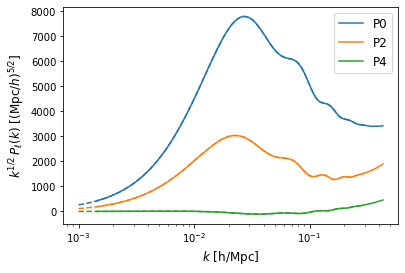

In [16]:
# Plot the results!
f = plt.figure()
ax = f.add_subplot(111)

ax.semilogx(k_Mpc/params['h'], (k_Mpc/params['h'])**0.5*Pell_Mpc_2[0]*params['h']**3,c='C0',ls='-',label='P0')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_hMpc_2[0],c='C0',ls='--')

ax.semilogx(k_Mpc/params['h'], (k_Mpc/params['h'])**0.5*Pell_Mpc_2[1]*params['h']**3,c='C1',ls='-',label='P2')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_hMpc_2[1],c='C1',ls='--')

ax.semilogx(k_Mpc/params['h'], (k_Mpc/params['h'])**0.5*Pell_Mpc_2[2]*params['h']**3,c='C2',ls='-',label='P4')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_hMpc_2[2],c='C2',ls='--')

ax.set_xlabel('$k$ [h/Mpc]',fontsize=12)
ax.set_ylabel(r'$k^{1/2}\,P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{5/2}$]',fontsize=12)
ax.legend(fontsize=12)

## Using a specific cosmology parameter space

We don't have to specify parameters in terms of `s12`, `alpha_lo`, `alpha_tr` and `f`, but instead we can provide the argument `de_model` in order to obtain predictions directly in terms of the corresponding cosmological parameters. Currently, `de_model` can either be `lambda`, `w0` or `w0wa`, in which cases one must include the Hubble rate `h`, the scalar amplitude of fluctuations `As`, the redshift `z`, and potentially `w0` and `wa` in the parameter dictionary. Optionally, it is also possible to specify the curvature density parameter at present time, `Ok`, in order to obtain predictions for non-flast cosmologies. A corresponding model is used to make the parameter conversions and since the computation of the Alcock-Paczynski parameters requires a fiducial cosmology we first need to specify the corresponding parameter values as follows:

In [17]:
params_fid_Minerva = {'h':0.695, 'wc':0.11544, 'wb':0.0222191, 'z':0.57}

# This assumes by default a "lambda" cosmology with w0 = -1, a non-flat cosmology is assumed if `params_fid` includes the key `Ok`.
# For other dark energy models one can set `de_model` to `w0` or `w0wa`, in which case one needs to provide the values for w0, wa in `params_fid`.
EFT.define_fiducial_cosmology(params_fid=params_fid_Minerva, de_model='lambda')

Next, we specify the three additional $\Lambda$CDM parameters in the dictionary (keeping the three shape parameters $\omega_c$, $\omega_b$ and $n_s$ fixed from before):

In [18]:
params['h']  = 0.8
params['As'] = 2.3
params['z']  = 0.6

Let's generate multipoles for this parameter set for the same range of scales as above (remembering that the emulator is still configured in Mpc/h units):

In [19]:
Pell_LCDM_hMpc_1 = EFT.Pell(k_hMpc, params, ell=[0,2,4], de_model='lambda') # E.g., this is for a flat LCDM cosmology

This function call ignores the values of `s12`, `alpha_tr`, `alpha_lo` and `f` in the parameter dictionary and instead converts the $\Lambda$CDM parameters to the $\sigma_{12}$ parameter space. The internal values of those parameters (which can be accessed via `EFT.params`) have therefore been updated:

In [20]:
# s12, alpha_tr, alpha_lo and f are different now!
EFT.params

{'wc': 0.11544,
 'wb': 0.0222191,
 'ns': 0.9632,
 's12': 0.5899231555066402,
 'alpha_tr': 0.9351278483373812,
 'alpha_lo': 0.907511539034901,
 'f': 0.704307243777837,
 'b1': 2.0,
 'b2': -0.5,
 'g2': -0.3,
 'g21': 0.0,
 'c0': -4.0,
 'c2': 0.0,
 'c4': 0.0,
 'cnlo': 6.0,
 'N0': 0.6,
 'N20': 0.0,
 'N22': 0.0,
 'h': 0.8,
 'As': 2.3,
 'Ok': 0.0,
 'w0': -1,
 'wa': 0.0,
 'z': 0.6}

When using the function `Pell` for a specific cosmology model we can specify the additional argument `alpha_tr_lo` that sets the AP parameters explicitly. For example, if one intends to ignore AP distortions one can compute:

In [21]:
Pell_LCDM_hMpc_2 = EFT.Pell(k_hMpc, params, ell=[0,2,4], de_model='lambda', alpha_tr_lo=[1,1])

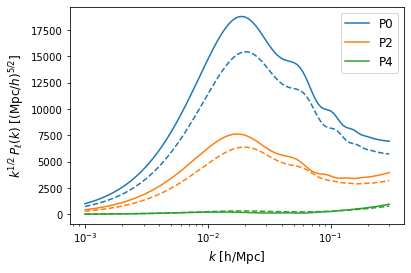

In [22]:
# The results differ accordingly!
f = plt.figure()
ax = f.add_subplot(111)

ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM_hMpc_1[0],c='C0',ls='-',label='P0')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM_hMpc_2[0],c='C0',ls='--')

ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM_hMpc_1[1],c='C1',ls='-',label='P2')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM_hMpc_2[1],c='C1',ls='--')

ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM_hMpc_1[2],c='C2',ls='-',label='P4')
ax.semilogx(k_hMpc, k_hMpc**0.5*Pell_LCDM_hMpc_2[2],c='C2',ls='--')

ax.set_xlabel('$k$ [h/Mpc]',fontsize=12)
ax.set_ylabel(r'$k^{1/2}\,P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{5/2}$]',fontsize=12)
ax.legend(fontsize=12)

# Computing covariance matrices

Apart from the multipoles we can also generate (Gaussian) covariance matrices, for which there are again two functions, `Pell_covariance` and `Pell_covariance_LCDM`, that are either defined for the $\sigma_{12}$ or the $\Lambda$CDM parameter spaces. The first three arguments, `k`, `params`, and `ell`, are identical to those for `Pell` and `Pell_LCDM`. In addition, we need to specify a binwidth `dk` and volume (both of which need to be given in the respective units for which the emulator is configured in), for example:

In [23]:
dk_hMpc = 0.001
k_hMpc_lin = np.arange(0.001, 0.3, dk_hMpc)
Cov_hMpc = EFT.Pell_covariance(k_hMpc_lin, params, ell=[0,2,4], dk=dk_hMpc, volume=3e9)

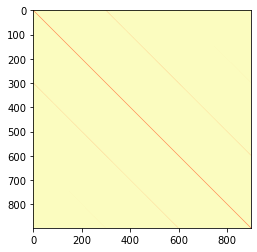

In [24]:
var_inv = np.diag(1./np.sqrt(np.diag(Cov_hMpc)))
R_hMpc = var_inv @ Cov_hMpc @ var_inv
plt.imshow(R_hMpc,cmap='magma_r')

For the specific cosmology version, instead of providing a volume, we can provide minimum and maximum redshifts, `zmin` and `zmax`, a sky fraction `fsky`, and a volume scaling factor `volfac` (by default equal to 1), which computes then evalutes the corresponding volume, also assuming the corresponding model. As before, in that case `Pell_covariance` can also take the optional `alpha_tr_lo` argument. For example:

In [25]:
Cov_hMpc_LCDM = EFT.Pell_covariance(k_hMpc_lin, params, ell=[0,2,4], dk=dk_hMpc, de_model='lambda', zmin=0.8, zmax=1.0, fsky=15000./(360**2/np.pi))

# Computing chi-squares

Finally, the PTEmu class provides a function to directly compute chi-squares. In order to do so, we need to specify the data set, i.e., range of scales of the observations, the measured multipoles and their covariance matrix. As before, these must be given in the same unit system as that for which the emulator has been configured.

In [26]:
# Loading a sample data set:
data = np.loadtxt('../data/cmass/Minerva_HOD_zs_z0.57_pkmulti_mean.dat')
cov = np.loadtxt('../data/cmass/Minerva_HOD_zs_z0.57_pkmulti_covar.dat')

# We have the option of specifying whether the covariance matrix is a "theory" covariance matrix or not. If `theory_cov = False`, 
# the Anderson-Hartlap factor is included in the inverse covariance matrix, which is why we need to also provide the number of realizations
# from which the covariance matrix was estimated (if `theory_cov = True`, `Nrealizations` can be ignored).
EFT.define_data_set(use_Mpc=False, k_data=data[:,0], P_data=data[:,[1,3,5]], Cov_data=cov, theory_cov=False, Nrealizations=300)

Now we can call `chi2`, which takes as arguments the parameter dictionary, a maximum k-mode value `kmax`, the dark energy model argument `de_model` and the `alpha_tr_lo` argument. `kmax` can either be a number, in which case the same cutoff is applied for all multipoles, or a list of numbers for each individual multipole. If the cutoff is zero (or smaller than the minimum scale of the observations) for a particular multipole, then it is excluded from the computation of the chi-square. `kmax` is also assumed to be in the units of the emulator. If `de_model` is not set (`de_model=None`) the $\sigma_{12}$ parameter space is assumed, otherwise it can be set to the same values as for `Pell` described above and the corresponding parameters need to be provided in the dictionary. In the latter case, the `alpha_tr_lo` can again be used to fix the AP parameters as explained above.

In [27]:
# Example for cutoff scales of 0.25 h/Mpc for the monopole, 0.15 h/Mpc for the quadrupole, 0.1 h/Mpc for the hexadecapole and using the s12 parameter space
EFT.chi2(params, kmax=[0.25,0.15,0.1])

39006.894715935865

In [28]:
# And another for a universal scale cut of 0.2 h/Mpc for all three multipoles and using the LCDM parameter space
EFT.chi2(params, kmax=0.2, de_model='lambda')

69295.75224335825

# The Fits file format